In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
from scipy import stats

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [2]:
nfl = pd.read_csv('../../data/nfl_game_by_game_raw_stats.csv')

In [3]:
nfl.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,qb_rush_yards,qb_rushing_epa,qb_rush_tds,total_qb_rush_attempts,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,sacks_allowed_team,qb_hits_allowed_team,fumbles_team,lost_fumbles_team,interceptions_thrown_team,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,total_epa,total_opposing_epa
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,26,110.0,-7.697317,0.0,7.779734,30.0,1.681309,0.0,3.0,2.0,4.0,1.0,1.0,0.0,2.0,4.0,2.0,2.0,0.0,24,52.0,-8.805075,1.0,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,1.0,0.0,-4.751772,1.654976,-1.654976
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,25,123.0,2.559394,1.0,24.116820,15.0,0.272050,0.0,3.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,28,139.0,4.264254,3.0,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,-1.162613,5.183908,-5.183908
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,21,94.0,-0.093163,1.0,-3.078329,7.0,1.793058,0.0,3.0,3.0,6.0,0.0,0.0,1.0,3.0,6.0,1.0,1.0,1.0,24,81.0,-4.888501,0.0,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,-2.107624,-13.436091,13.436091
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,31,197.0,4.315138,1.0,0.591515,23.0,0.222908,1.0,4.0,1.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,18,86.0,-0.055888,0.0,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,2.0,1.0,3.721131,15.216262,-15.216262
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,33,113.0,-6.247634,0.0,10.352312,10.0,1.929123,0.0,3.0,1.0,3.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,17,102.0,1.025410,0.0,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,2.0,1.0,-3.457676,8.130204,-8.130204


In [4]:
# Previous iteration tried to predict passing value using a modeling approach. The issue I found with this is that it 
# is difficult to create a label corresponding to a "good" quarterback game. In this approach, the focus will be 
# transforming the necessary features using scaling/normalization/etc. This approach should result in minimal changes
# to the actual value of the feature, just changing the representation.

In [5]:
# Get pass defense stats

pass_def = nfl.copy()
pass_def = pass_def[['season', 'week', 'team', 'opponent', 'score', 'opponent_score', 'total_pass_attempts_allowed', 'passing_yards_allowed',
        'completions_allowed', 'passing_epa_allowed', 'pass_tds_allowed', 'air_yards_allowed', 'yards_after_catch_allowed', 'air_epa_allowed', 'yac_epa_allowed', 'avg_cpoe_allowed',
        'qb_epa_allowed', 'qb_rush_yards_allowed', 'qb_rushing_epa_allowed', 'qb_rush_tds_allowed', 'sacks', 'qb_hits', 'fumbles_forced',
        'fumbles_recovered', 'interceptions']]
pass_def = pass_def.drop_duplicates()
pass_def

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5864,2022,21,KC,CIN,23,20,41,270.0,26.0,-1.830367,1.0,151.0,119.0,6.690806,11.780224,8.062006,1.656690,30.0,3.487057,0.0,5.0,11.0,0.0,0.0,2.0
5865,2022,21,PHI,SF,31,7,18,97.0,11.0,-7.338993,0.0,31.0,66.0,-0.208252,5.490642,-0.534539,-11.930165,2.0,-4.591173,0.0,3.0,7.0,2.0,2.0,0.0
5866,2022,21,SF,PHI,7,31,25,121.0,15.0,-0.657053,0.0,71.0,50.0,0.958878,8.566836,-2.605077,0.835513,39.0,1.492567,1.0,1.0,2.0,0.0,0.0,0.0
5869,2022,22,KC,PHI,38,35,38,304.0,28.0,12.892024,1.0,222.0,117.0,9.827818,12.079392,14.972010,15.172346,72.0,2.280322,3.0,2.0,2.0,1.0,0.0,0.0


In [6]:
# Look at the distribution of passing epa. Should it be left as is? Scaled?

np.mean(pass_def.qb_epa_allowed)

2.2668207458675105

In [7]:
np.max(pass_def.qb_epa_allowed)

40.139698

In [8]:
np.min(pass_def.qb_epa_allowed)

-39.694508

In [9]:
best_pass_performances = pass_def.sort_values(by='qb_epa_allowed', ascending=False)
best_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
268,2014,8,IND,PIT,34,51,49,522.0,40.0,36.206100,6.0,296.0,226.0,18.347322,23.776966,16.915632,40.139698,-1.0,-1.443085,0.0,0.0,0.0,2.0,2.0,0.0
3184,2019,1,MIA,BAL,10,59,26,379.0,23.0,37.989697,6.0,218.0,161.0,14.612830,26.266829,28.640444,37.886658,17.0,-0.103038,0.0,1.0,1.0,0.0,0.0,0.0
3310,2019,5,ATL,HOU,32,53,33,426.0,28.0,32.197030,5.0,222.0,204.0,15.549741,20.956861,17.858105,36.080143,47.0,3.883114,0.0,0.0,1.0,3.0,0.0,0.0
3877,2020,3,BAL,KC,20,34,42,385.0,31.0,31.377850,4.0,207.0,178.0,6.965472,32.178870,9.400512,35.252430,26.0,3.874581,1.0,0.0,4.0,1.0,1.0,0.0
5028,2021,16,BAL,CIN,21,41,46,525.0,37.0,32.462337,4.0,279.0,246.0,13.691797,31.177887,14.204991,34.681343,12.0,2.219006,0.0,3.0,6.0,0.0,0.0,0.0
4646,2021,5,MIA,TB,17,45,43,452.0,33.0,32.273087,5.0,214.0,238.0,4.560706,37.390137,15.150119,33.138477,13.0,0.865391,0.0,2.0,6.0,0.0,0.0,0.0
3398,2019,7,LV,GB,24,42,31,429.0,25.0,31.815393,5.0,206.0,223.0,8.283893,29.595753,20.738749,32.614830,6.0,0.799438,1.0,1.0,3.0,0.0,0.0,0.0
452,2014,13,TEN,HOU,21,45,33,358.0,24.0,21.103912,6.0,178.0,180.0,12.331483,14.888274,10.078753,32.544125,10.0,1.401261,0.0,0.0,3.0,1.0,1.0,0.0
5185,2022,1,ARI,KC,21,44,39,360.0,30.0,28.897123,5.0,168.0,192.0,6.068593,27.857737,11.784186,32.338684,5.0,-0.849840,0.0,0.0,6.0,3.0,1.0,0.0
3190,2019,1,NYG,DAL,17,35,32,405.0,25.0,30.217525,4.0,232.0,173.0,15.304371,21.021845,8.916627,31.767210,14.0,1.549685,0.0,0.0,2.0,0.0,0.0,0.0


In [10]:
worst_pass_performances = pass_def.sort_values(by='qb_epa_allowed', ascending=True)
worst_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
3222,2019,2,NE,MIA,43,0,39,186.0,18.0,-40.475357,0.0,125.0,61.0,-0.570181,9.589837,-16.102394,-39.694508,6.0,0.780851,0.0,7.0,11.0,0.0,0.0,4.0
2736,2018,7,DEN,ARI,45,10,39,194.0,21.0,-38.896610,1.0,122.0,72.0,1.744368,12.277300,-10.159547,-37.038696,14.0,1.857912,0.0,6.0,11.0,3.0,2.0,3.0
1902,2017,1,JAX,HOU,29,7,36,164.0,19.0,-38.545410,1.0,99.0,65.0,2.213864,8.475595,-12.172345,-36.269028,16.0,2.276384,0.0,10.0,10.0,3.0,3.0,1.0
3338,2019,5,PHI,NYJ,31,6,27,120.0,15.0,-34.976100,0.0,38.0,82.0,-6.899850,12.142971,-7.548871,-34.976100,0.0,0.000000,0.0,10.0,16.0,2.0,1.0,2.0
1816,2016,17,ARI,LA,44,6,28,143.0,17.0,-38.571790,0.0,20.0,123.0,-9.428609,13.428546,-11.436937,-34.950590,-1.0,-0.089809,0.0,7.0,8.0,4.0,1.0,2.0
5072,2021,17,CHI,NYG,29,3,11,24.0,4.0,-35.564820,0.0,0.0,24.0,-3.608493,2.536155,-29.181055,-34.458668,13.0,1.106152,0.0,4.0,5.0,3.0,2.0,2.0
437,2014,13,LA,LV,52,0,48,230.0,29.0,-32.219470,0.0,122.0,108.0,-5.489212,18.887900,-11.377539,-32.817547,1.0,-0.598075,0.0,6.0,7.0,3.0,2.0,3.0
3402,2019,7,NE,NYJ,33,0,32,86.0,11.0,-31.661474,0.0,67.0,19.0,1.590615,1.916720,-22.019503,-31.661474,0.0,0.000000,0.0,1.0,2.0,1.0,1.0,4.0
2132,2017,8,BAL,MIA,40,0,44,176.0,25.0,-31.465069,0.0,122.0,54.0,-1.331060,6.678736,-10.349047,-31.465069,0.0,0.000000,0.0,3.0,7.0,0.0,0.0,2.0
3439,2019,8,SF,CAR,51,13,37,158.0,19.0,-31.149303,0.0,73.0,85.0,-0.510800,9.992088,-16.359425,-31.149303,0.0,0.000000,0.0,7.0,9.0,0.0,0.0,3.0


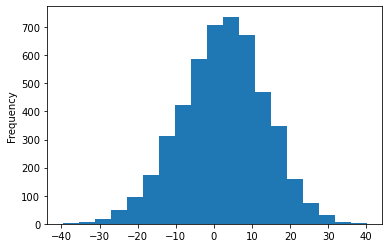

In [11]:
pass_def.qb_epa_allowed.plot.hist(bins=19)

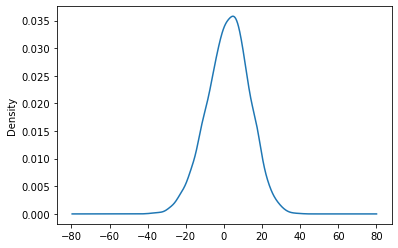

In [12]:
pass_def.qb_epa_allowed.plot.kde()

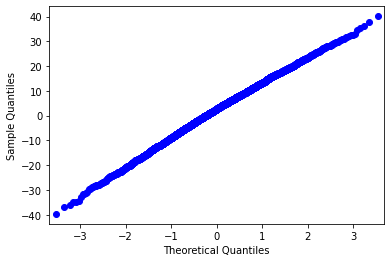

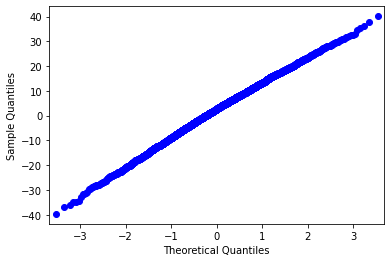

In [13]:
sm.qqplot(pass_def.qb_epa_allowed)

In [14]:
# Looks normal, creating a variable to normalize passing_epa

# Note, if want to do a per play qb epa, need to go back and add qb rush attempts to the data frame

qb_epa_allowed_mean = np.mean(pass_def.qb_epa_allowed)
qb_epa_allowed_std = np.std(pass_def.qb_epa_allowed)
pass_def['qb_epa_allowed_standardized'] = pass_def.apply(lambda x: (x.qb_epa_allowed - qb_epa_allowed_mean)/qb_epa_allowed_std, axis=1)

pass_def.head()

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,qb_epa_allowed_standardized
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0,-0.361331
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,1.047285
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,0.457796
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0,-0.198708
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0,-0.531960


In [15]:
# Still not sure whats best. Per attempt gives higher praise for good games w few passes and penalized more heavily for
# bad games with fewer passes. Going to start with total, but may need to change this later.

# A positive epa allowed indicates that the defense performed poorly. To make the value system more intuitive, going to 
# flip the sign for defensive value. This way, high values mean good performances for both offense and defense.
# This shouldnt make a difference for the algorithms, but it will make the data more easily interpretable

passing_def_to_save = pass_def.copy()
passing_def_to_save['qb_def_value'] = -passing_def_to_save.qb_epa_allowed_standardized
passing_def_to_save.head()

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,qb_epa_allowed_standardized,qb_def_value
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0,-0.361331,0.361331
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,1.047285,-1.047285
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,0.457796,-0.457796
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0,-0.198708,0.198708
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0,-0.531960,0.531960


In [16]:
passing_def_to_save.to_csv('qb_defense_value_model_v2_data/qb_def_with_value.csv')

In [17]:
# Look at best/worst def by passing epa standardized

pdef = pass_def.groupby(by=['team']).agg({'qb_epa_allowed_standardized': 'mean', 'week':'count'}).reset_index()
pdef

,team,qb_epa_allowed_standardized,week
0,ARI,-0.072634,150
1,ATL,0.271064,151
2,BAL,-0.118755,153
3,BUF,-0.253740,154
4,CAR,-0.051488,152
5,CHI,0.051089,148
6,CIN,0.005883,154
7,CLE,0.115867,148
8,DAL,-0.082511,154
9,DEN,-0.247414,150


In [18]:
pdef.sort_values(by='qb_epa_allowed_standardized', ascending = True).head(20)

,team,qb_epa_allowed_standardized,week
3,BUF,-0.253740,154
9,DEN,-0.247414,150
16,LA,-0.210535,156
20,MIN,-0.201183,152
21,NE,-0.196873,162
26,PIT,-0.125417,155
2,BAL,-0.118755,153
25,PHI,-0.085618,156
8,DAL,-0.082511,154
27,SEA,-0.074963,158


In [20]:
pdef.sort_values(by='qb_epa_allowed_standardized', ascending = False).head(20)

,team,qb_epa_allowed_standardized,week
18,LV,0.336133,148
10,DET,0.279487,148
1,ATL,0.271064,151
23,NYG,0.148392,149
31,WAS,0.138427,148
24,NYJ,0.132202,146
30,TEN,0.130867,153
19,MIA,0.127621,148
7,CLE,0.115867,148
14,JAX,0.078112,151


In [ ]:
pdef2 = pass_def.groupby(by=['team', 'season']).agg({'passing_epa_allowed_standardized': 'mean', 'week':'count'}).reset_index()
pdef2

In [ ]:
pdef2.sort_values(by='passing_epa_allowed_standardized', ascending = False).head(20)

In [ ]:
pdef2.sort_values(by='passing_epa_allowed_standardized', ascending = True).head(20)